# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


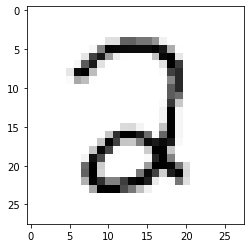

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2372
Training Accuracy: 0.7264, Testing Accuracy: 0.7485



Epoch 10, Loss 0.0734
Training Accuracy: 0.9276, Testing Accuracy: 0.9380



Epoch 20, Loss 0.0494
Training Accuracy: 0.9465, Testing Accuracy: 0.9561



Epoch 30, Loss 0.0405
Training Accuracy: 0.9538, Testing Accuracy: 0.9637



Epoch 40, Loss 0.0358
Training Accuracy: 0.9574, Testing Accuracy: 0.9672



Epoch 50, Loss 0.0329
Training Accuracy: 0.9611, Testing Accuracy: 0.9682



Epoch 60, Loss 0.0308
Training Accuracy: 0.9635, Testing Accuracy: 0.9682



Epoch 70, Loss 0.0291
Training Accuracy: 0.9650, Testing Accuracy: 0.9703



Epoch 80, Loss 0.0279
Training Accuracy: 0.9673, Testing Accuracy: 0.9708



Epoch 90, Loss 0.0268
Training Accuracy: 0.9685, Testing Accuracy: 0.9703



Epoch 100, Loss 0.0258
Training Accuracy: 0.9700, Testing Accuracy: 0.9713



Epoch 110, Loss 0.025
Training Accuracy: 0.9710, Testing Accuracy: 0.9718



Epoch 120, Loss 0.0243
Training Accuracy: 0.9719, Testing Accuracy: 0.9718



Epoch 130, Loss 0.0237
Training Accuracy: 0.9728, Testing Accuracy: 0.9718



Epoch 140, Loss 0.0231
Training Accuracy: 0.9736, Testing Accuracy: 0.9718



Epoch 150, Loss 0.0225
Training Accuracy: 0.9745, Testing Accuracy: 0.9718



Epoch 160, Loss 0.022
Training Accuracy: 0.9755, Testing Accuracy: 0.9708



Epoch 170, Loss 0.0215
Training Accuracy: 0.9762, Testing Accuracy: 0.9723



Epoch 180, Loss 0.021
Training Accuracy: 0.9766, Testing Accuracy: 0.9723



Epoch 190, Loss 0.0206
Training Accuracy: 0.9770, Testing Accuracy: 0.9728



Epoch 200, Loss 0.0202
Training Accuracy: 0.9775, Testing Accuracy: 0.9733



Epoch 210, Loss 0.0198
Training Accuracy: 0.9780, Testing Accuracy: 0.9733



Epoch 220, Loss 0.0194
Training Accuracy: 0.9784, Testing Accuracy: 0.9753



Epoch 230, Loss 0.019
Training Accuracy: 0.9787, Testing Accuracy: 0.9748



Epoch 240, Loss 0.0186
Training Accuracy: 0.9791, Testing Accuracy: 0.9753



0.030301747600723464

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2288
Training Accuracy: 0.7393, Testing Accuracy: 0.7409



Epoch 10, Loss 0.1055
Training Accuracy: 0.9004, Testing Accuracy: 0.9103



Epoch 20, Loss 0.0813
Training Accuracy: 0.9210, Testing Accuracy: 0.9355



Epoch 30, Loss 0.0698
Training Accuracy: 0.9338, Testing Accuracy: 0.9481



Epoch 40, Loss 0.0629
Training Accuracy: 0.9397, Testing Accuracy: 0.9536



Epoch 50, Loss 0.0582
Training Accuracy: 0.9434, Testing Accuracy: 0.9561



Epoch 60, Loss 0.0547
Training Accuracy: 0.9461, Testing Accuracy: 0.9577



Epoch 70, Loss 0.052
Training Accuracy: 0.9485, Testing Accuracy: 0.9597



Epoch 80, Loss 0.0499
Training Accuracy: 0.9508, Testing Accuracy: 0.9607



Epoch 90, Loss 0.0481
Training Accuracy: 0.9519, Testing Accuracy: 0.9607



Epoch 100, Loss 0.0466
Training Accuracy: 0.9527, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0454
Training Accuracy: 0.9537, Testing Accuracy: 0.9622



Epoch 120, Loss 0.0443
Training Accuracy: 0.9547, Testing Accuracy: 0.9627



Epoch 130, Loss 0.0433
Training Accuracy: 0.9559, Testing Accuracy: 0.9642



Epoch 140, Loss 0.0424
Training Accuracy: 0.9568, Testing Accuracy: 0.9652



Epoch 150, Loss 0.0417
Training Accuracy: 0.9573, Testing Accuracy: 0.9657



Epoch 160, Loss 0.041
Training Accuracy: 0.9582, Testing Accuracy: 0.9662



Epoch 170, Loss 0.0403
Training Accuracy: 0.9584, Testing Accuracy: 0.9667



Epoch 180, Loss 0.0398
Training Accuracy: 0.9585, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0392
Training Accuracy: 0.9586, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0387
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0383
Training Accuracy: 0.9589, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0379
Training Accuracy: 0.9594, Testing Accuracy: 0.9672



Epoch 230, Loss 0.0375
Training Accuracy: 0.9595, Testing Accuracy: 0.9667



Epoch 240, Loss 0.0371
Training Accuracy: 0.9597, Testing Accuracy: 0.9662



0.03692466845129534

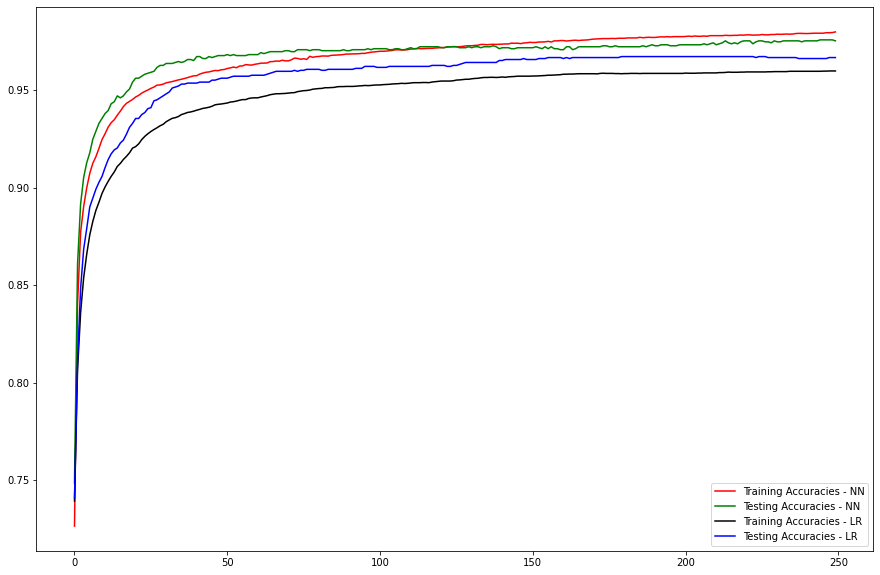

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

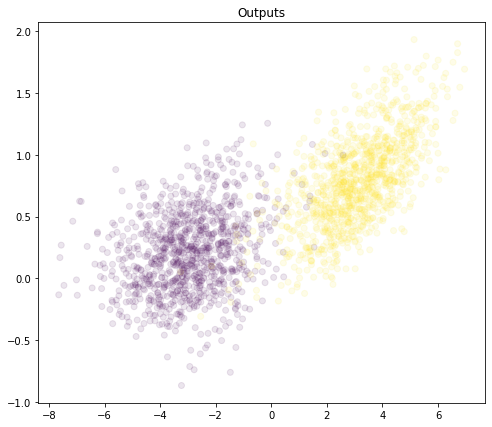

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

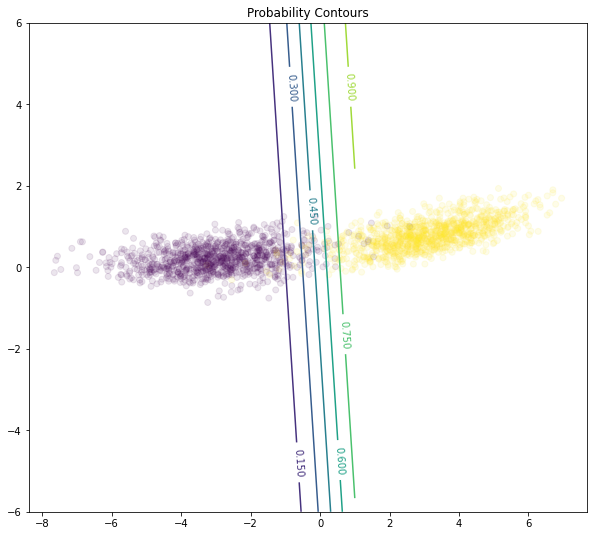

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );